# Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, accuracy_score

# Data Load

In [2]:
def load_data(fold_no) :
    train_sw_iou = pd.read_csv('./iou/train_sw_iou(fold{}).csv'.format(fold_no), header=None)
    train_nsw_iou = pd.read_csv('./iou/train_nsw_iou(fold{}).csv'.format(fold_no), header=None)

    test_sw_iou = pd.read_csv('./iou/test_sw_iou(fold{}).csv'.format(fold_no), header=None)
    test_nsw_iou = pd.read_csv('./iou/test_nsw_iou(fold{}).csv'.format(fold_no), header=None)
    
    train_iou = pd.concat([train_sw_iou, train_nsw_iou], axis=0)
    test_iou = pd.concat([test_sw_iou, test_nsw_iou], axis=0)

    train_x = np.array(train_iou)
    test_x = np.array(test_iou)
    
    train_y = np.array([1]*len(train_sw_iou) + [0]*len(train_nsw_iou))
    test_y = np.array([1]*len(test_sw_iou) + [0]*len(test_nsw_iou))
    
    # shuffle
    s = np.arange(train_x.shape[0])
    np.random.shuffle(s)

    train_x = train_x[s]
    train_y = train_y[s]
    
    return train_x, train_y, test_x, test_y

# Training

In [3]:
def classification_optimal_thres(scores, threshold):
    pred = []
    for s in scores:
        if s > threshold:
            pred.append(1)
        else:
            pred.append(0)
    return pred

* cross validation

----- Fold 1 ------
AUC:  0.9607453057535897
Accuracy: 0.9013732833957553


              precision    recall  f1-score   support

   non-smile       0.84      0.96      0.90       368
       smile       0.96      0.85      0.90       433

    accuracy                           0.90       801
   macro avg       0.90      0.91      0.90       801
weighted avg       0.91      0.90      0.90       801

----- Fold 2 ------
AUC:  0.9719035545737524
Accuracy: 0.920099875156055


              precision    recall  f1-score   support

   non-smile       0.93      0.89      0.91       368
       smile       0.91      0.95      0.93       433

    accuracy                           0.92       801
   macro avg       0.92      0.92      0.92       801
weighted avg       0.92      0.92      0.92       801

----- Fold 3 ------
AUC:  0.938575634057971
Accuracy: 0.88875


              precision    recall  f1-score   support

   non-smile       0.84      0.93      0.88       368
       smile       0.9

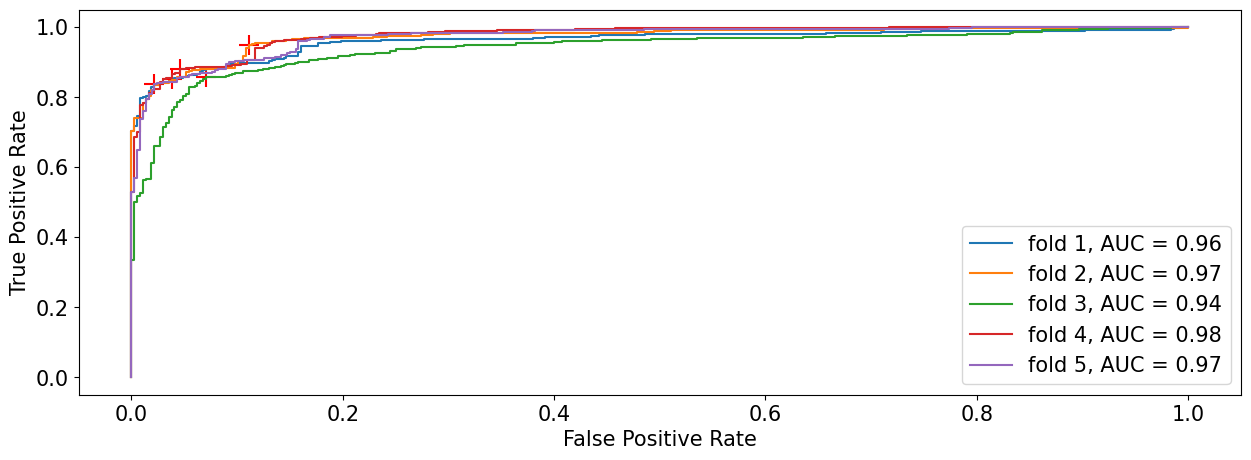

------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 0.9047480109343923 (+- 0.010719406140463197)


In [4]:
plt.rc('font', size=15)
plt.figure(figsize=(15,5))

acc_list = []
for fold_no in range(1,6) :
    train_x, train_y, test_x, test_y = load_data(fold_no)
    
    svm_clf = svm.SVC(kernel = 'rbf', C=10, gamma=0.001, probability=True)
    svm_clf.fit(train_x, train_y)
    
    y_prob = svm_clf.predict_proba(test_x) 
    y_pred = svm_clf.predict(test_x)

    fpr, tpr, thresholds = roc_curve(test_y, y_prob[:,1])
    auc_value = auc(fpr, tpr)

    optimal_idx = np.argmax(tpr-fpr)
    optimal_trhd = thresholds[optimal_idx]
    sens, spec = tpr[optimal_idx], 1-fpr[optimal_idx]
    
    y_pred_opt = classification_optimal_thres(y_prob[:,1], optimal_trhd)
    acc_list.append(accuracy_score(list(test_y), y_pred_opt))
    
    print("----- Fold {} ------".format(fold_no))
    print("AUC: ", auc_value)
    print("Accuracy: "+str(accuracy_score(list(test_y), y_pred_opt)))
    print('\n')
    print(classification_report(test_y, y_pred_opt, target_names=['non-smile', 'smile']))
    
    plt.plot(fpr, tpr, label='fold {}, AUC = {:.2f}'.format(fold_no
                                                            , roc_auc_score(y_true=test_y, y_score=y_prob[:,1])))
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='+', s=200, color='r')
    
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_list)} (+- {np.std(acc_list)})')